In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder as label, StandardScaler, power_transform, OrdinalEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.utils import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime
from imblearn.over_sampling import SMOTE
from numpy.random import RandomState
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_palette(['#06B1F0', '#FC4B60'])
random_seed = 63445

In [2]:
train_org = pd.read_csv("../input/airbnb-new-user/train.csv")
dsession = pd.read_csv("../input/airbnb-new-user/sessions.csv")
dcountries = pd.read_csv("../input/airbnb-new-user/countries.csv")
dage_g = pd.read_csv("../input/airbnb-new-user/age_gender_bkts.csv")
test_org = pd.read_csv("../input/airbnb-new-user/test.csv")

In [3]:
train_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       170137 non-null  object 
 1   date_account_created     170137 non-null  object 
 2   timestamp_first_active   170137 non-null  int64  
 3   date_first_booking       72330 non-null   object 
 4   gender                   170137 non-null  object 
 5   age                      101368 non-null  float64
 6   signup_method            170137 non-null  object 
 7   signup_flow              170137 non-null  int64  
 8   language                 170137 non-null  object 
 9   affiliate_channel        170137 non-null  object 
 10  affiliate_provider       170137 non-null  object 
 11  first_affiliate_tracked  164110 non-null  object 
 12  signup_app               170137 non-null  object 
 13  first_device_type        170137 non-null  object 
 14  firs

In [4]:
train_org.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         97807
gender                         0
age                        68769
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6027
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [5]:
test_org.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         26736
gender                         0
age                        19221
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       38
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [7]:
train_org['country_destination'].value_counts()

NDF      97807
US       50864
other     8075
FR        4163
IT        2268
GB        1881
ES        1824
CA        1124
DE         906
NL         601
AU         461
PT         163
Name: country_destination, dtype: int64

**We observe that number of null values for date_first_booking is same as number of times the country destination is NDF. So we remove all columns from the training data for which the value in date_first_booking was null.**

In [8]:
test_dfb = test_org['date_first_booking']
train_org = train_org.dropna(subset=['date_first_booking'])

In [9]:
train_org['country_destination'].value_counts()

US       50864
other     8075
FR        4163
IT        2268
GB        1881
ES        1824
CA        1124
DE         906
NL         601
AU         461
PT         163
Name: country_destination, dtype: int64

**The categorical features are - 
Gender.
signup_method.
language.
affiliate channel.
affiliate provider.
first_affiliate_tracked.
signup_app.
first_device_type.
first_browser.**

**Let's first look at categorical features-**

In [10]:
#Gender
train_org['gender'].value_counts()

FEMALE       26478
-unknown-    22997
MALE         22707
OTHER          148
Name: gender, dtype: int64

gender     country_destination
-unknown-  US                     16090
           other                   2673
           FR                      1376
           IT                       774
           GB                       584
           ES                       561
           CA                       372
           DE                       228
           NL                       172
           AU                       119
           PT                        48
FEMALE     US                     18724
           other                   2608
           FR                      1664
           IT                       920
           GB                       725
           ES                       695
           CA                       366
           DE                       320
           NL                       206
           AU                       187
           PT                        63
MALE       US                     15952
           other                   2777
         

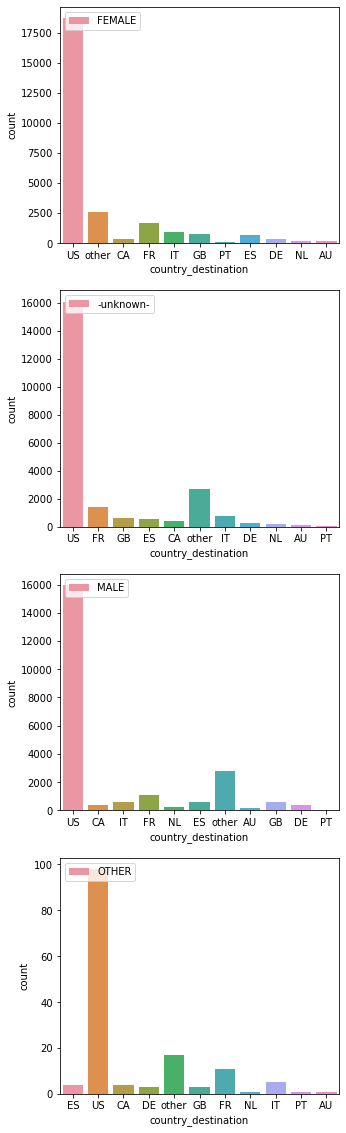

In [11]:
j=0
f, ax = plt.subplots(ncols=1,nrows=4,figsize=(5, 20))
for i in train_org['gender'].unique():
    sns.countplot(train_org.loc[train_org['gender'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

In [12]:
#Signup_method
train_org['signup_method'].value_counts()

basic       52485
facebook    19845
Name: signup_method, dtype: int64

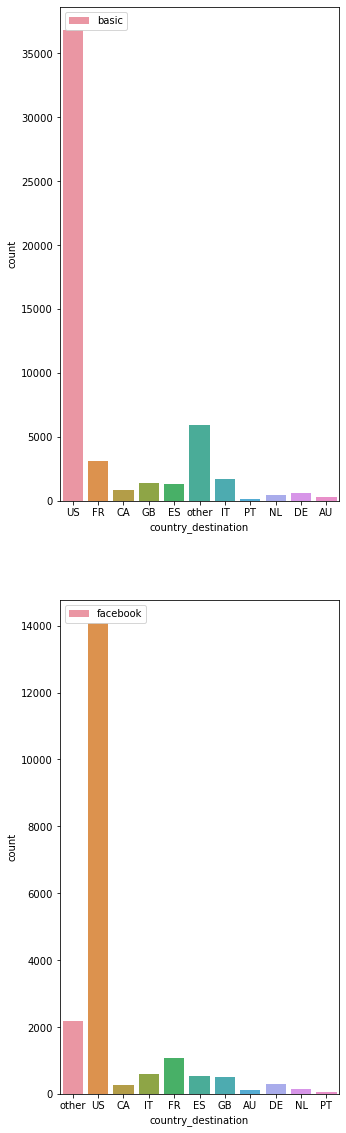

In [13]:
j=0
f, ax = plt.subplots(ncols=1,nrows=2,figsize=(5, 20))
for i in train_org['signup_method'].unique():
    sns.countplot(train_org.loc[train_org['signup_method'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

In [14]:
#Language
train_org['language'].value_counts()

en    70556
zh      372
fr      334
de      237
es      227
ko      161
it       88
ru       87
ja       62
pt       50
sv       39
nl       31
da       19
tr       18
pl       12
no       12
cs        8
fi        6
hu        3
el        3
th        2
ca        2
is        1
Name: language, dtype: int64

In [19]:
#Affiliate_channel
train_org['affiliate_channel'].value_counts()

direct           48402
sem-brand         7497
sem-non-brand     6180
other             3503
seo               3257
api               2761
content            472
remarketing        258
Name: affiliate_channel, dtype: int64

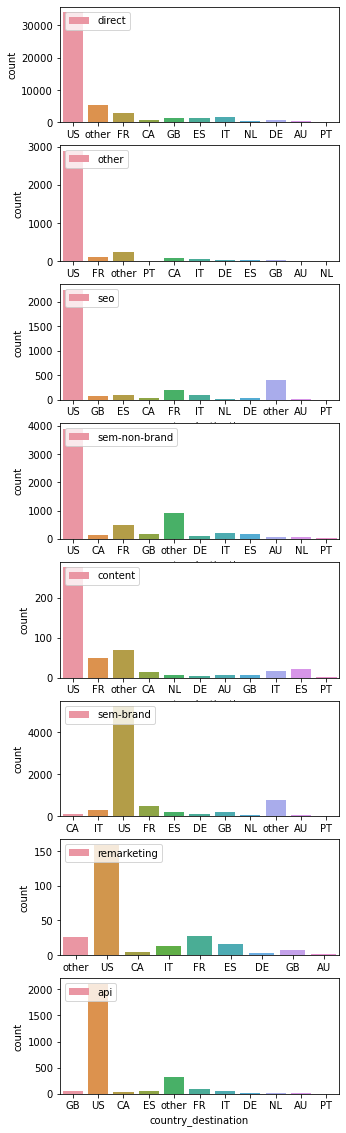

In [20]:
j=0
f, ax = plt.subplots(ncols=1,nrows=8,figsize=(5, 20))
for i in train_org['affiliate_channel'].unique():
    sns.countplot(train_org.loc[train_org['affiliate_channel'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

In [22]:
#affiliate_provider
train_org['affiliate_provider'].value_counts()

direct                 48238
google                 15709
other                   4577
craigslist              1616
facebook                 681
bing                     589
vast                     271
padmapper                226
yahoo                    161
facebook-open-graph      134
meetup                    44
gsp                       37
email-marketing           25
naver                     14
baidu                      7
yandex                     1
Name: affiliate_provider, dtype: int64

In [28]:
#first_affiliate_tracked
train_org['first_affiliate_tracked'].value_counts()

untracked        39157
linked           16708
omg              12136
tracked-other     2123
product            404
marketing           59
local ops            5
Name: first_affiliate_tracked, dtype: int64

In [29]:
train_org['first_affiliate_tracked'] = train_org['first_affiliate_tracked'].fillna('null')

In [30]:
test_org['first_affiliate_tracked'] = test_org['first_affiliate_tracked'].fillna('null')

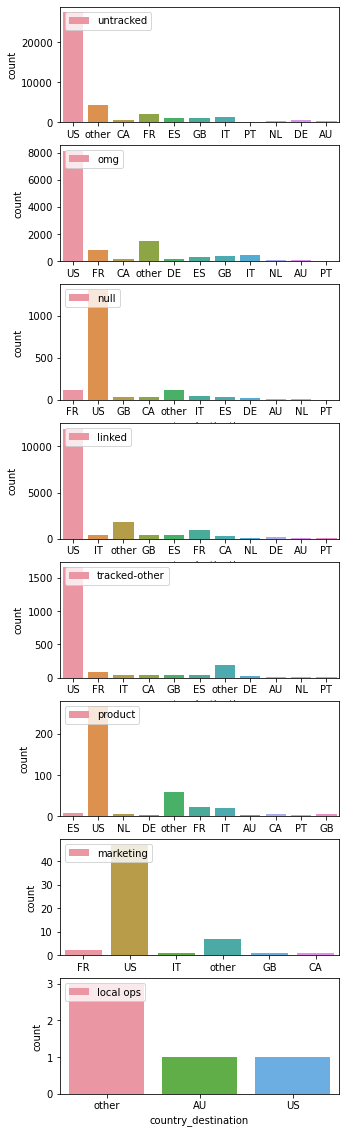

In [31]:
j=0
f, ax = plt.subplots(ncols=1,nrows=8,figsize=(5, 20))
for i in train_org['first_affiliate_tracked'].unique():
    sns.countplot(train_org.loc[train_org['first_affiliate_tracked'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

In [32]:
#signup_app
train_org['signup_app'].value_counts()

Web        66288
iOS         3624
Moweb       1673
Android      745
Name: signup_app, dtype: int64

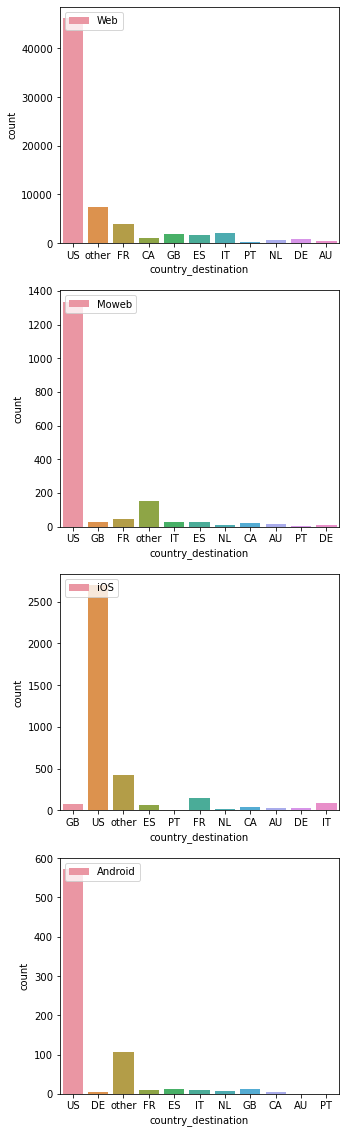

In [33]:
j=0
f, ax = plt.subplots(ncols=1,nrows=4,figsize=(5, 20))
for i in train_org['signup_app'].unique():
    sns.countplot(train_org.loc[train_org['signup_app'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

In [34]:
#first_device_type
train_org['first_device_type'].value_counts()

Mac Desktop           35303
Windows Desktop       24774
iPad                   4400
iPhone                 4153
Other/Unknown          2655
Desktop (Other)         433
Android Tablet          303
Android Phone           290
SmartPhone (Other)       19
Name: first_device_type, dtype: int64

In [37]:
#first_browser
train_org['first_browser'].value_counts()

Chrome                  24141
Safari                  16356
Firefox                 13528
IE                       6497
Mobile Safari            5558
-unknown-                5474
Chrome Mobile             235
Android Browser           230
AOL Explorer               58
Opera                      54
Chromium                   35
Silk                       34
BlackBerry Browser         21
Maxthon                    13
Apple Mail                 12
RockMelt                   11
Iron                        9
Mobile Firefox              8
Camino                      7
Sogou Explorer              6
SiteKiosk                   6
IceWeasel                   6
Pale Moon                   4
TenFourFox                  4
SeaMonkey                   4
wOSBrowser                  3
Opera Mini                  2
IE Mobile                   2
CoolNovo                    2
NetNewsWire                 1
Mozilla                     1
SlimBrowser                 1
Stainless                   1
Googlebot 

In [38]:
test_org['first_browser'].value_counts()

Chrome                12654
-unknown-              8797
Safari                 7705
Mobile Safari          4881
Firefox                4797
IE                     3470
Chrome Mobile           622
Android Browser         230
Silk                     26
Opera                    26
IE Mobile                18
Mobile Firefox           14
AOL Explorer             13
Chromium                 13
Sogou Explorer            8
Maxthon                   7
BlackBerry Browser        6
Apple Mail                6
IceWeasel                 4
Yandex.Browser            4
SiteKiosk                 3
CoolNovo                  2
Pale Moon                 2
Iron                      1
IceDragon                 1
Outlook 2007              1
TheWorld Browser          1
RockMelt                  1
Avant Browser             1
Name: first_browser, dtype: int64

**Now to the numerical/non-categorical features -
date_account_created.
timestamp_first_active.
date_first_booking.
age.
signup_flow.**

In [42]:
#date_account_created
train_org['date_account_created']

2         2010-09-28
3         2011-12-05
4         2010-09-14
5         2010-01-01
6         2010-01-02
             ...    
170118    2014-03-31
170122    2014-03-31
170125    2014-03-31
170128    2014-03-31
170134    2014-03-31
Name: date_account_created, Length: 72330, dtype: object

In [43]:
train_org['date_account_created'] = pd.to_datetime(train_org['date_account_created'])
train_org['date_first_booking'] = pd.to_datetime(train_org['date_first_booking'])
test_org['date_account_created'] = pd.to_datetime(test_org['date_account_created'])
test_org['date_first_booking'] = pd.to_datetime(test_org['date_first_booking'])

In [44]:
train_org['dac_year'] = train_org.date_account_created.dt.year
train_org['dac_month'] = train_org.date_account_created.dt.month
train_org['dac_day'] = train_org.date_account_created.dt.day
test_org['dac_year'] = test_org.date_account_created.dt.year
test_org['dac_month'] = test_org.date_account_created.dt.month
test_org['dac_day'] = test_org.date_account_created.dt.day

In [45]:
train_org.drop(['date_account_created'],axis = 1,inplace = True)
test_org.drop(['date_account_created'],axis = 1,inplace = True)

In [46]:
train_org['dac_year'].value_counts()

2013    33884
2012    17749
2014    12661
2011     6433
2010     1603
Name: dac_year, dtype: int64

In [47]:
test_org['dac_year'].value_counts()

2014    43314
Name: dac_year, dtype: int64

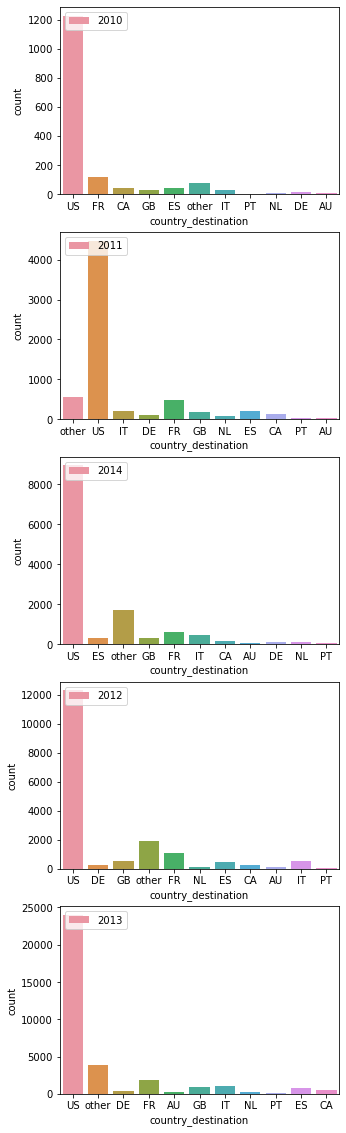

In [48]:
j=0
f, ax = plt.subplots(ncols=1,nrows=5,figsize=(5, 20))
for i in train_org['dac_year'].unique():
    sns.countplot(train_org.loc[train_org['dac_year'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

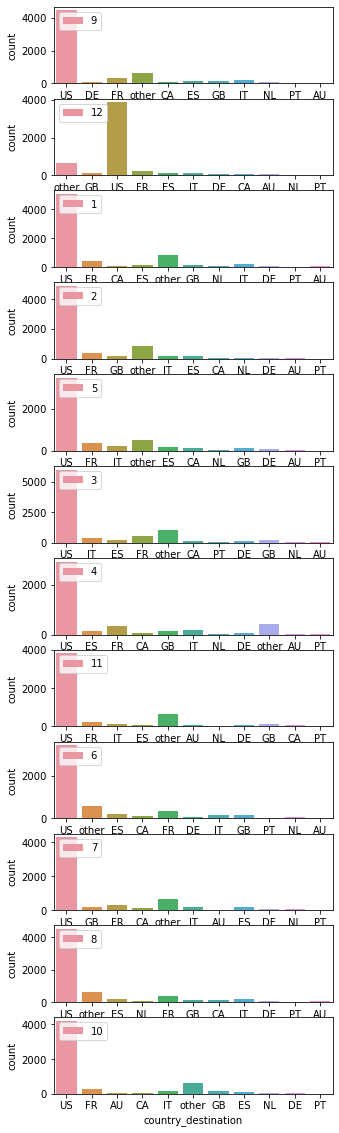

In [49]:
j=0
f, ax = plt.subplots(ncols=1,nrows=12,figsize=(5, 20))
for i in train_org['dac_month'].unique():
    sns.countplot(train_org.loc[train_org['dac_month'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

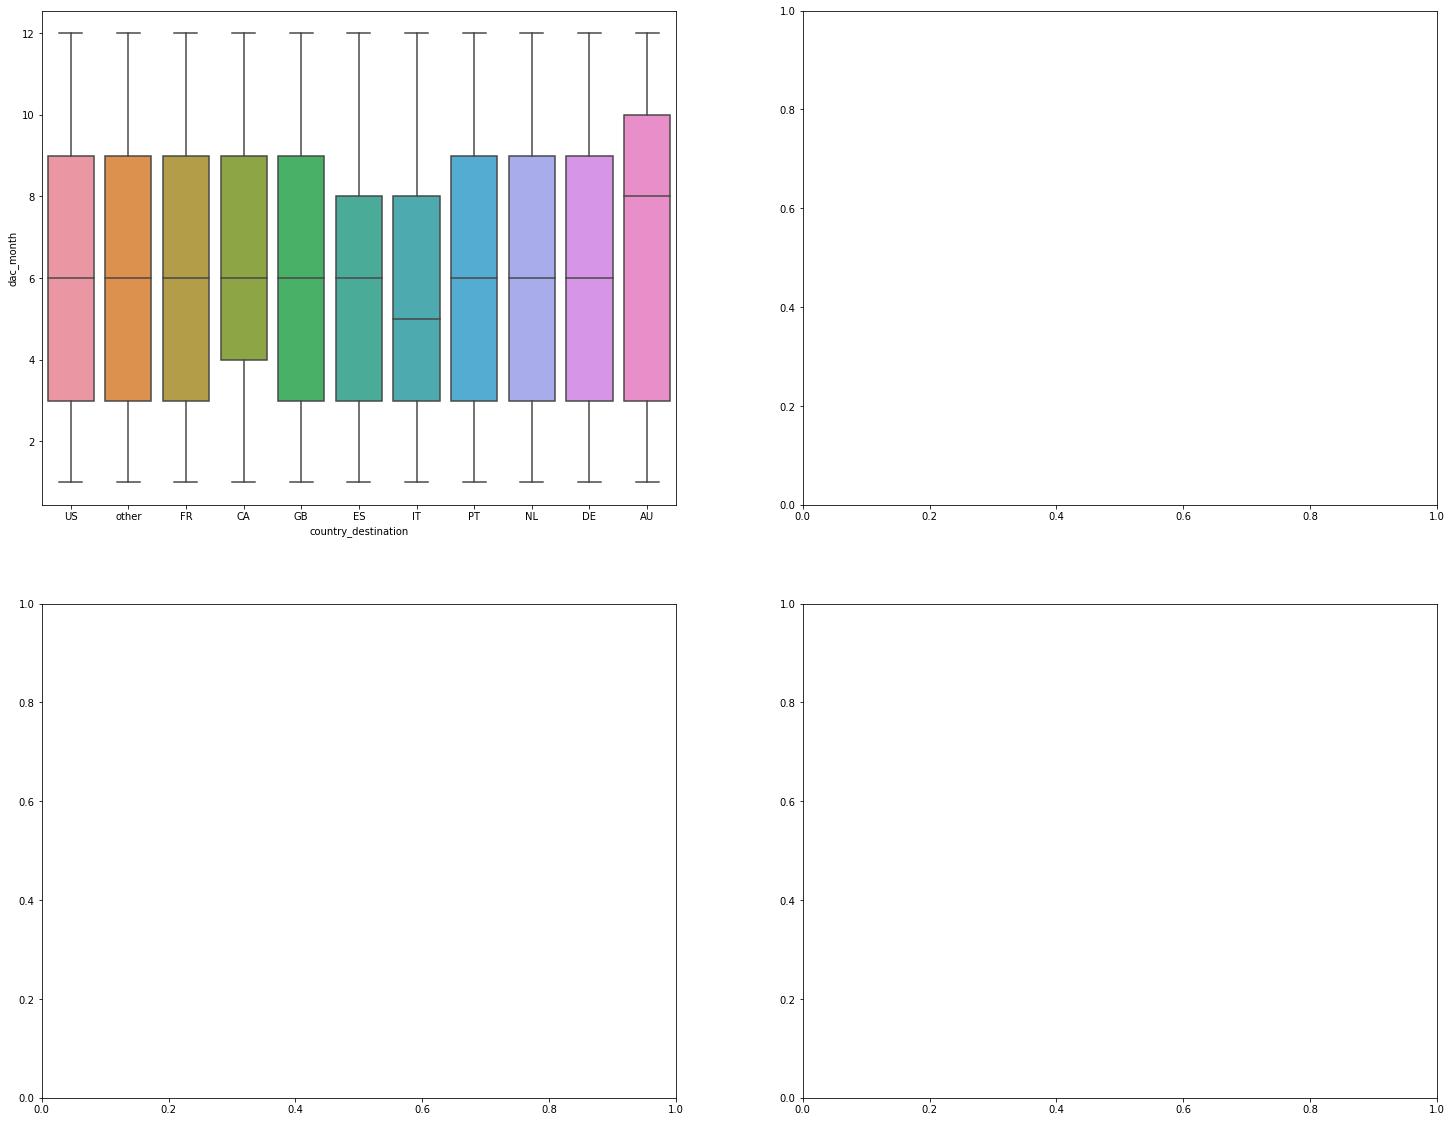

In [50]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='dac_month', data=train_org, ax=subplot)

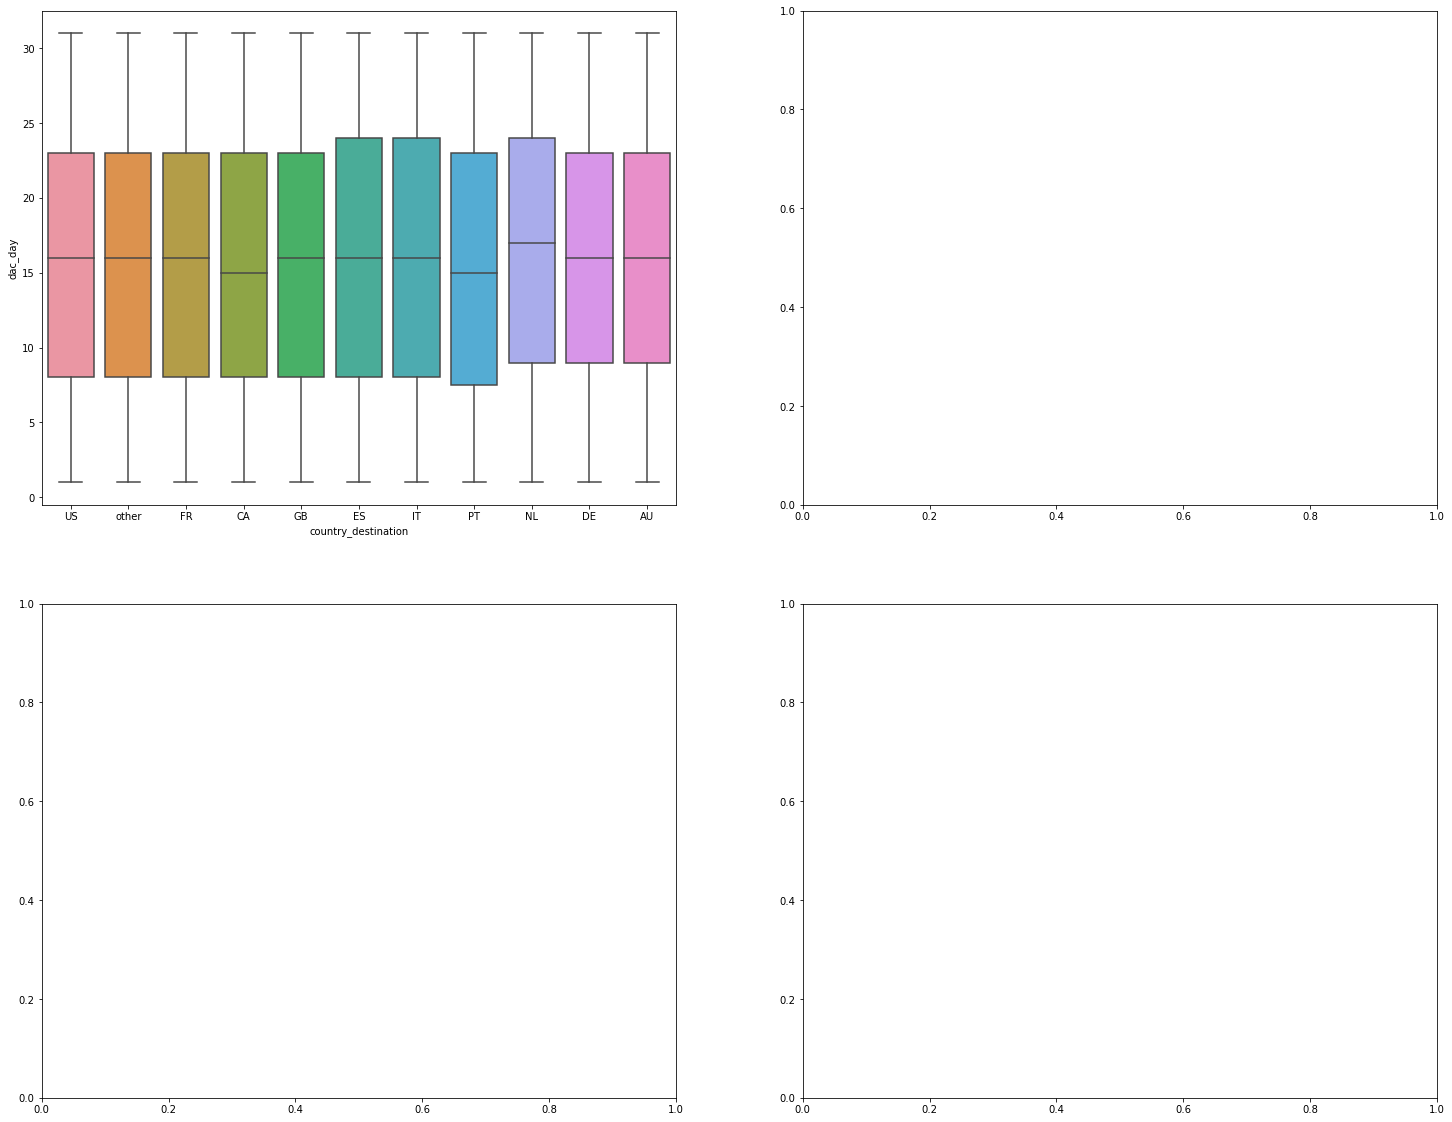

In [51]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='dac_day', data=train_org, ax=subplot)

In [52]:
train_org.drop(['dac_day','dac_month'],axis = 1,inplace = True)
test_org.drop(['dac_day','dac_month'],axis = 1,inplace = True)

In [53]:
#timestamp_first_active
train_org['timestamp_first_active']

2         20090609231247
3         20091031060129
4         20091208061105
5         20100101215619
6         20100102012558
               ...      
170118    20140331231906
170122    20140331232659
170125    20140331232944
170128    20140331233549
170134    20140331235546
Name: timestamp_first_active, Length: 72330, dtype: int64

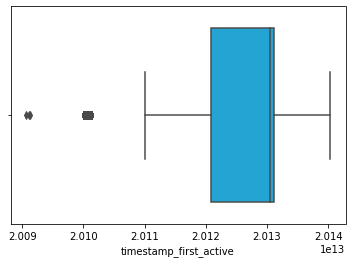

In [54]:
sns.boxplot(train_org['timestamp_first_active'])

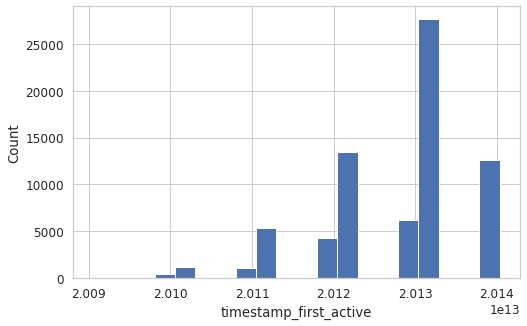

In [55]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train_org['timestamp_first_active'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='timestamp_first_active', ylabel='Count');

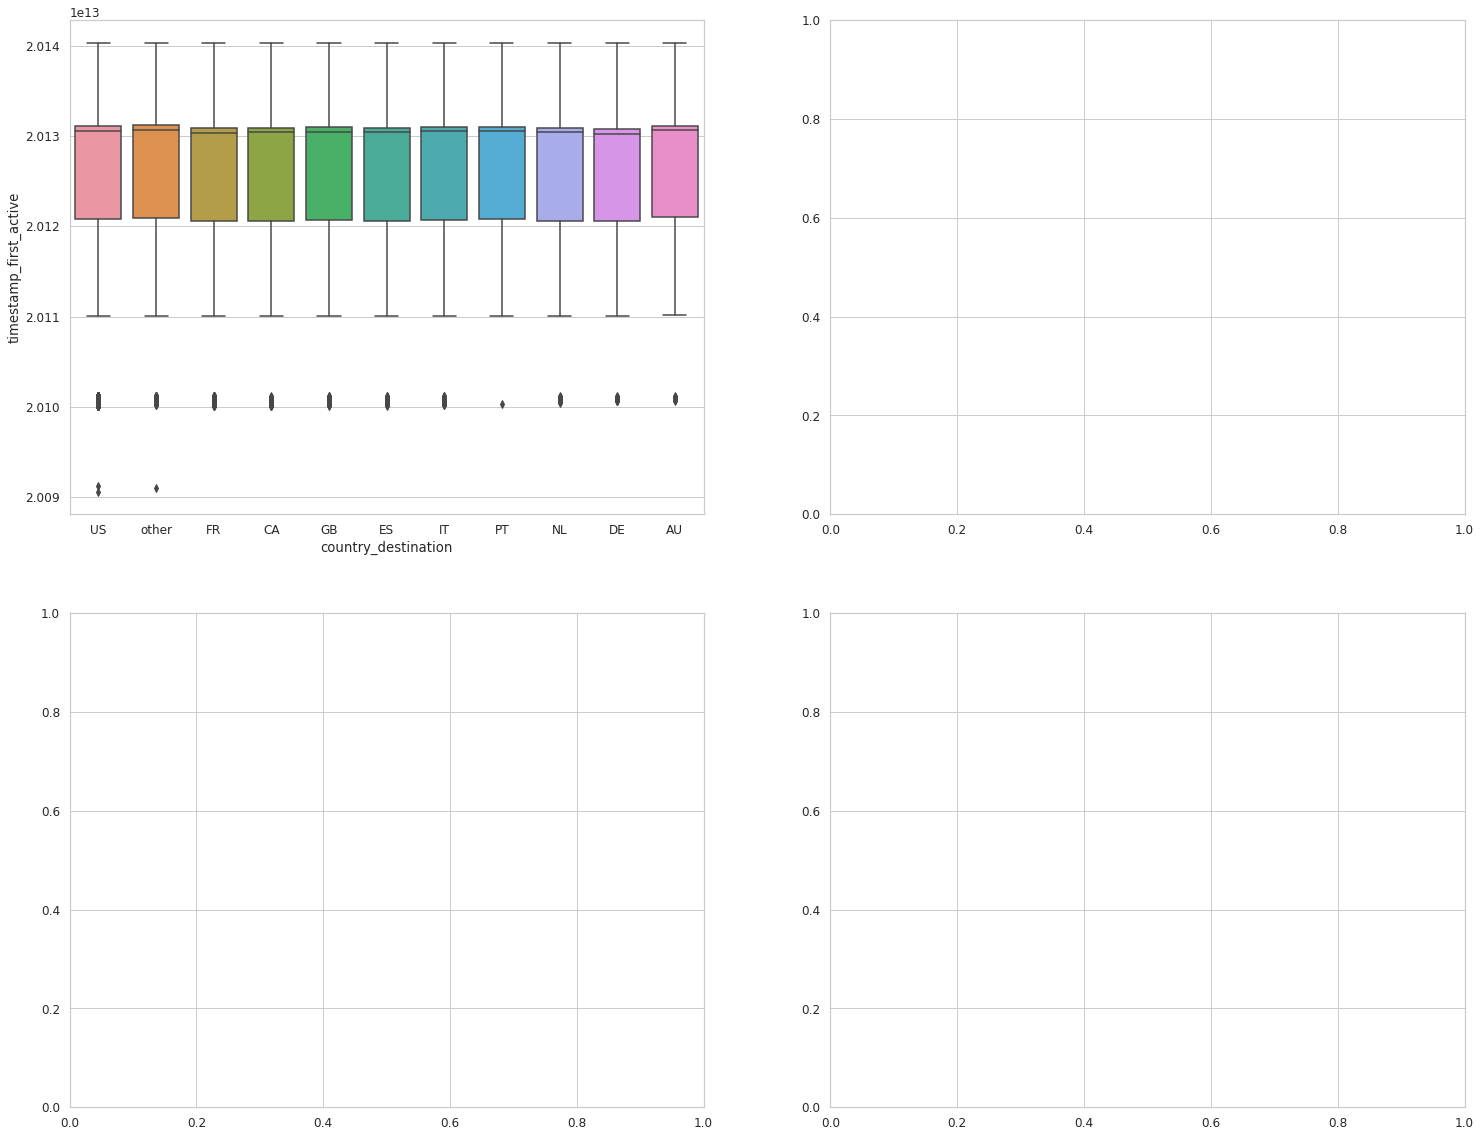

In [56]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='timestamp_first_active', data=train_org, ax=subplot)

**Therefore can drop this column. But let's dissect it into months, years and days -**

In [57]:
tfa = np.vstack(train_org.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
train_org['tfa_year'] = tfa[:,0]
train_org['tfa_month'] = tfa[:,1]
train_org['tfa_day'] = tfa[:,2]
tfa_t = np.vstack(test_org.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
test_org['tfa_year'] = tfa_t[:,0]
test_org['tfa_month'] = tfa_t[:,1]
test_org['tfa_day'] = tfa_t[:,2]

In [58]:
train_org['tfa_year'].value_counts()

2013    33881
2012    17758
2014    12639
2011     6439
2010     1610
2009        3
Name: tfa_year, dtype: int64

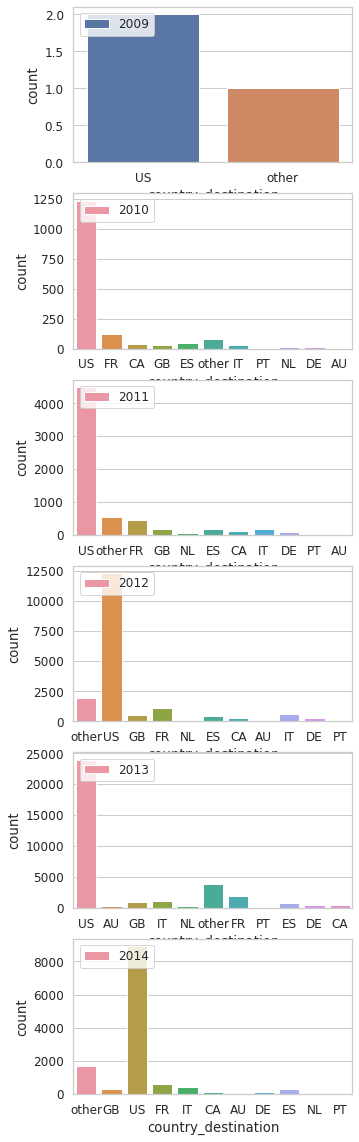

In [59]:
j=0
f, ax = plt.subplots(ncols=1,nrows=6,figsize=(5, 20))
for i in train_org['tfa_year'].unique():
    sns.countplot(train_org.loc[train_org['tfa_year'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

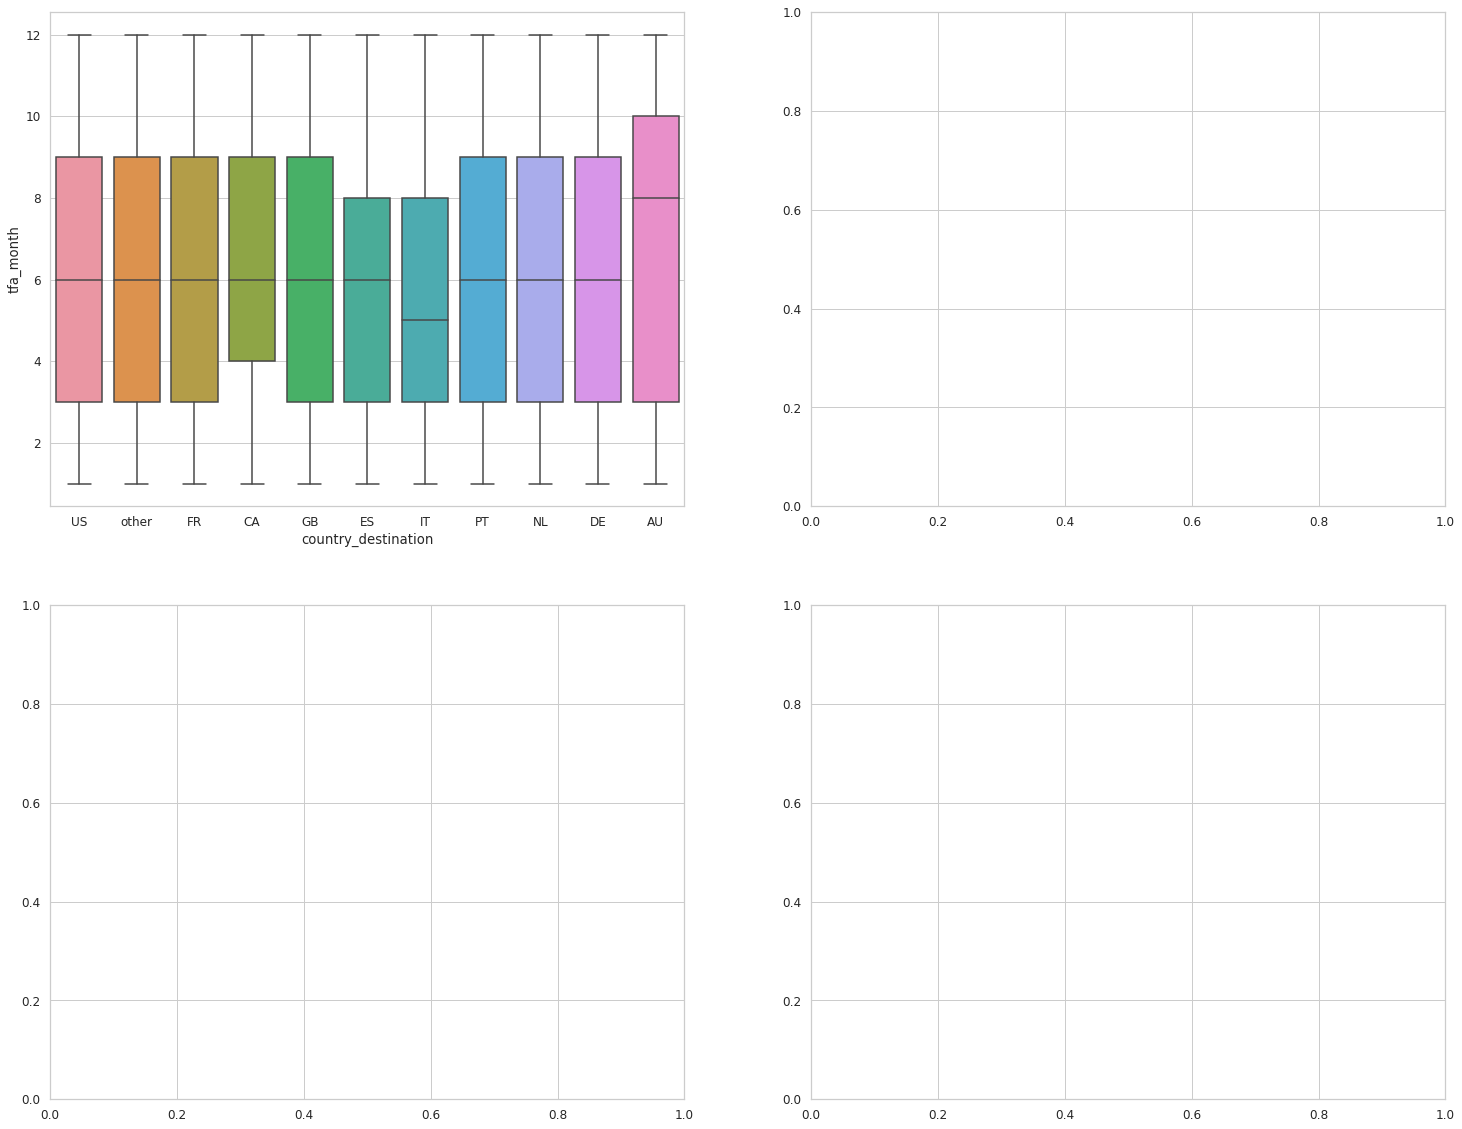

In [60]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='tfa_month', data=train_org, ax=subplot)

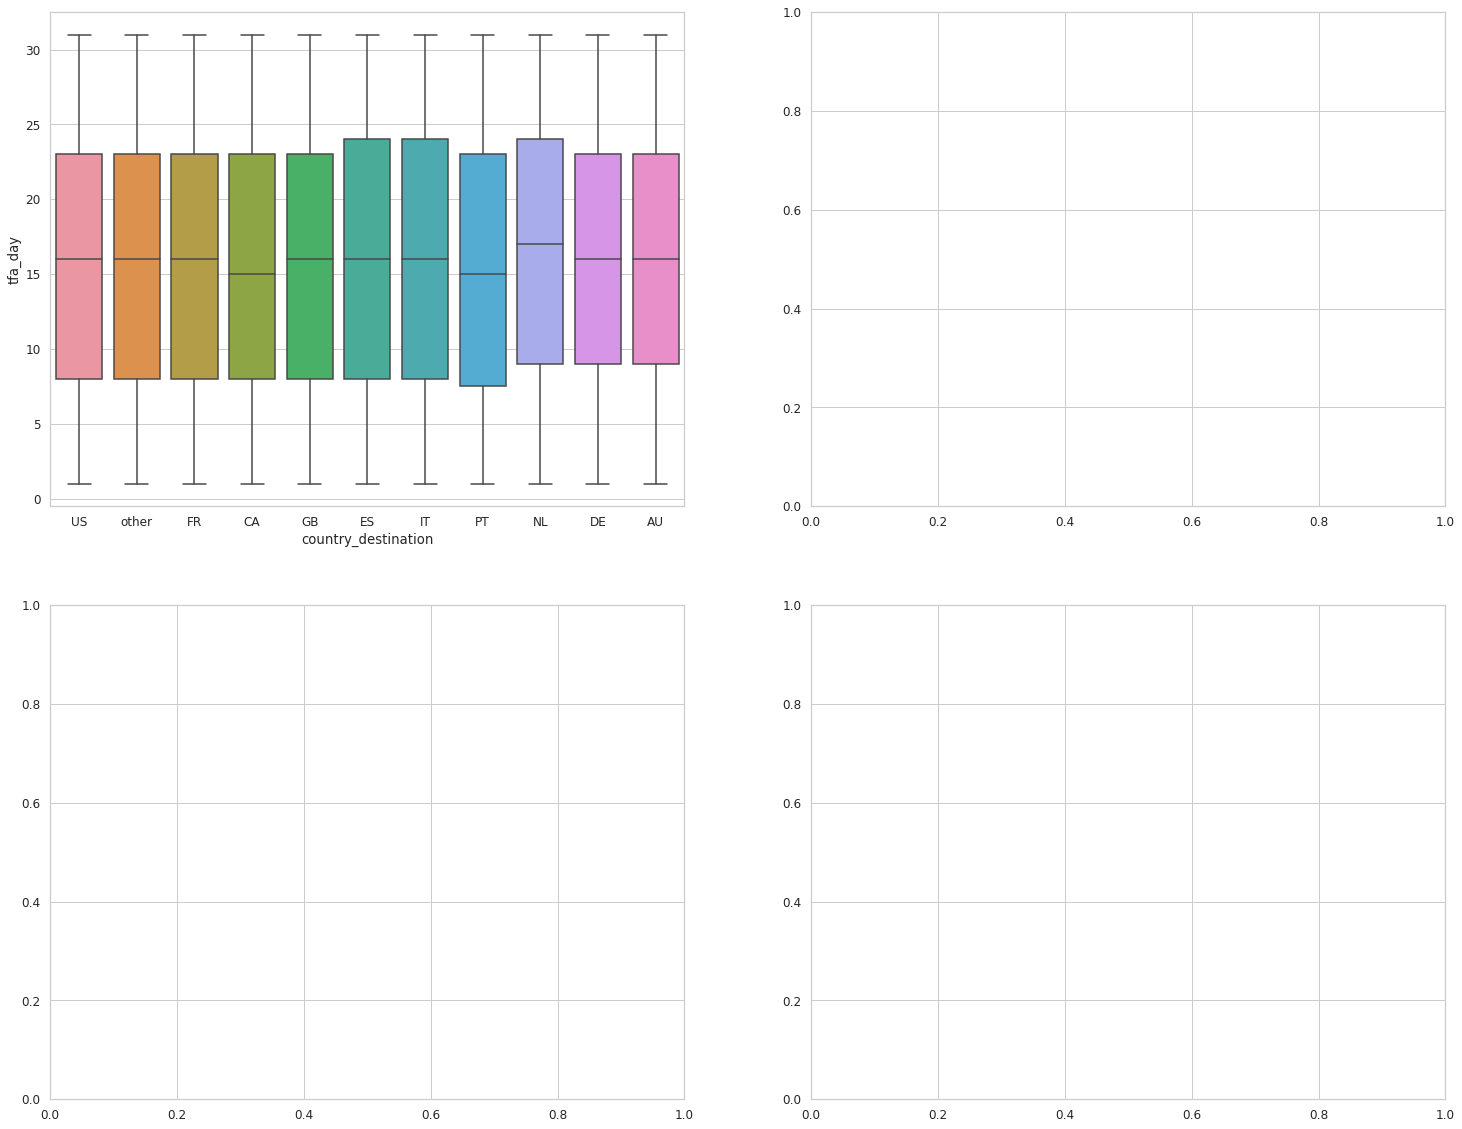

In [61]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='tfa_day', data=train_org, ax=subplot)

In [62]:
train_org.drop(['timestamp_first_active','tfa_day'],axis = 1,inplace = True)
test_org.drop(['timestamp_first_active','tfa_day'],axis = 1,inplace = True)

In [63]:
#date_first_booking
train_org['date_first_booking']

2        2010-08-02
3        2012-09-08
4        2010-02-18
5        2010-01-02
6        2010-01-05
            ...    
170118   2015-02-05
170122   2014-04-05
170125   2015-03-08
170128   2014-04-01
170134   2014-04-01
Name: date_first_booking, Length: 72330, dtype: datetime64[ns]

In [64]:
train_org['dfb_year'] = train_org.date_first_booking.dt.year
train_org['dfb_month'] = train_org.date_first_booking.dt.month
train_org['dfb_day'] = train_org.date_first_booking.dt.day
test_org['dfb_year'] = test_org.date_first_booking.dt.year
test_org['dfb_month'] = test_org.date_first_booking.dt.month
test_org['dfb_day'] = test_org.date_first_booking.dt.day

In [65]:
train_org.drop(['date_first_booking'],axis = 1,inplace = True)
test_org.drop(['date_first_booking'],axis = 1,inplace = True)

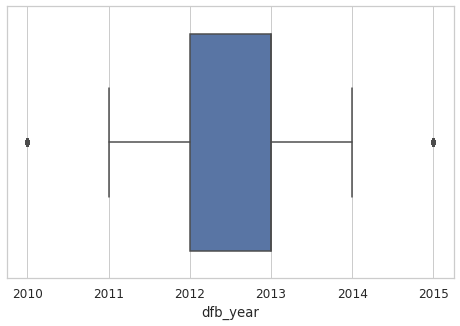

In [68]:
sns.boxplot(train_org['dfb_year'])

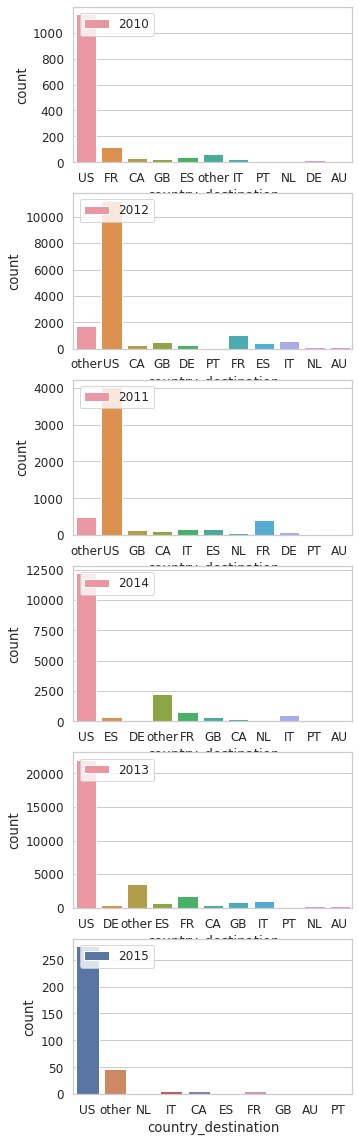

In [69]:
j=0
f, ax = plt.subplots(ncols=1,nrows=6,figsize=(5, 20))
for i in train_org['dfb_year'].unique():
    sns.countplot(train_org.loc[train_org['dfb_year'] == i, 'country_destination'],label = i,ax=ax[j])
    ax[j].legend(loc="upper left")
    j=j+1

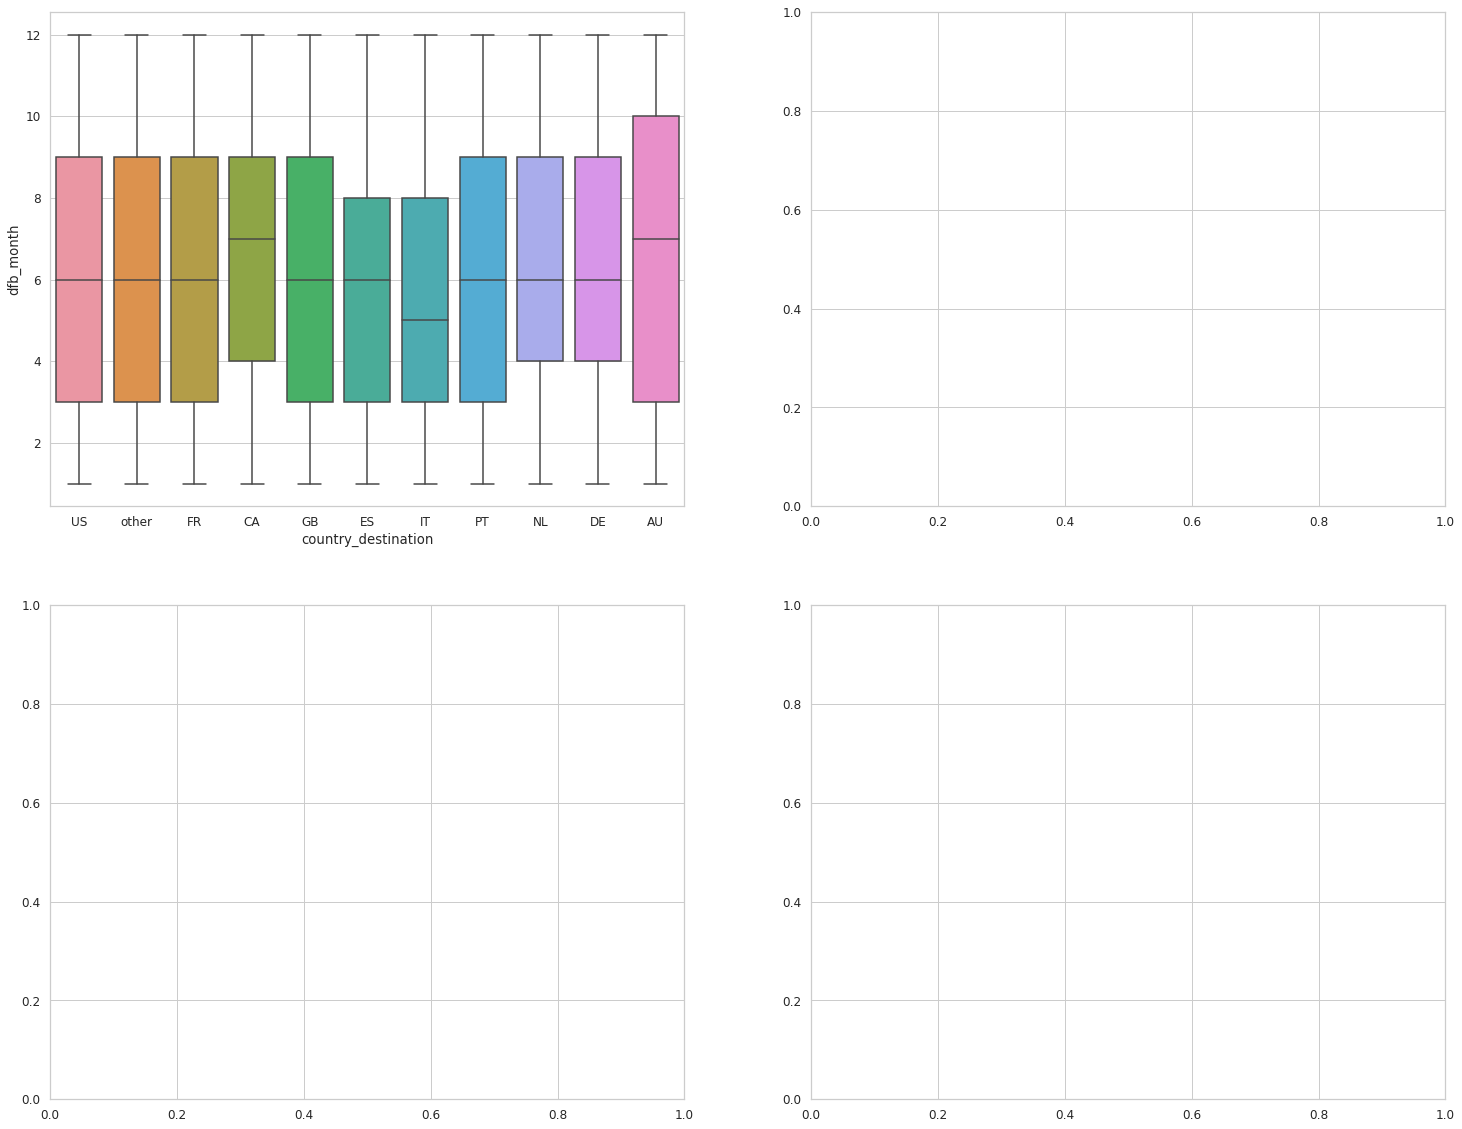

In [70]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='dfb_month', data=train_org, ax=subplot)

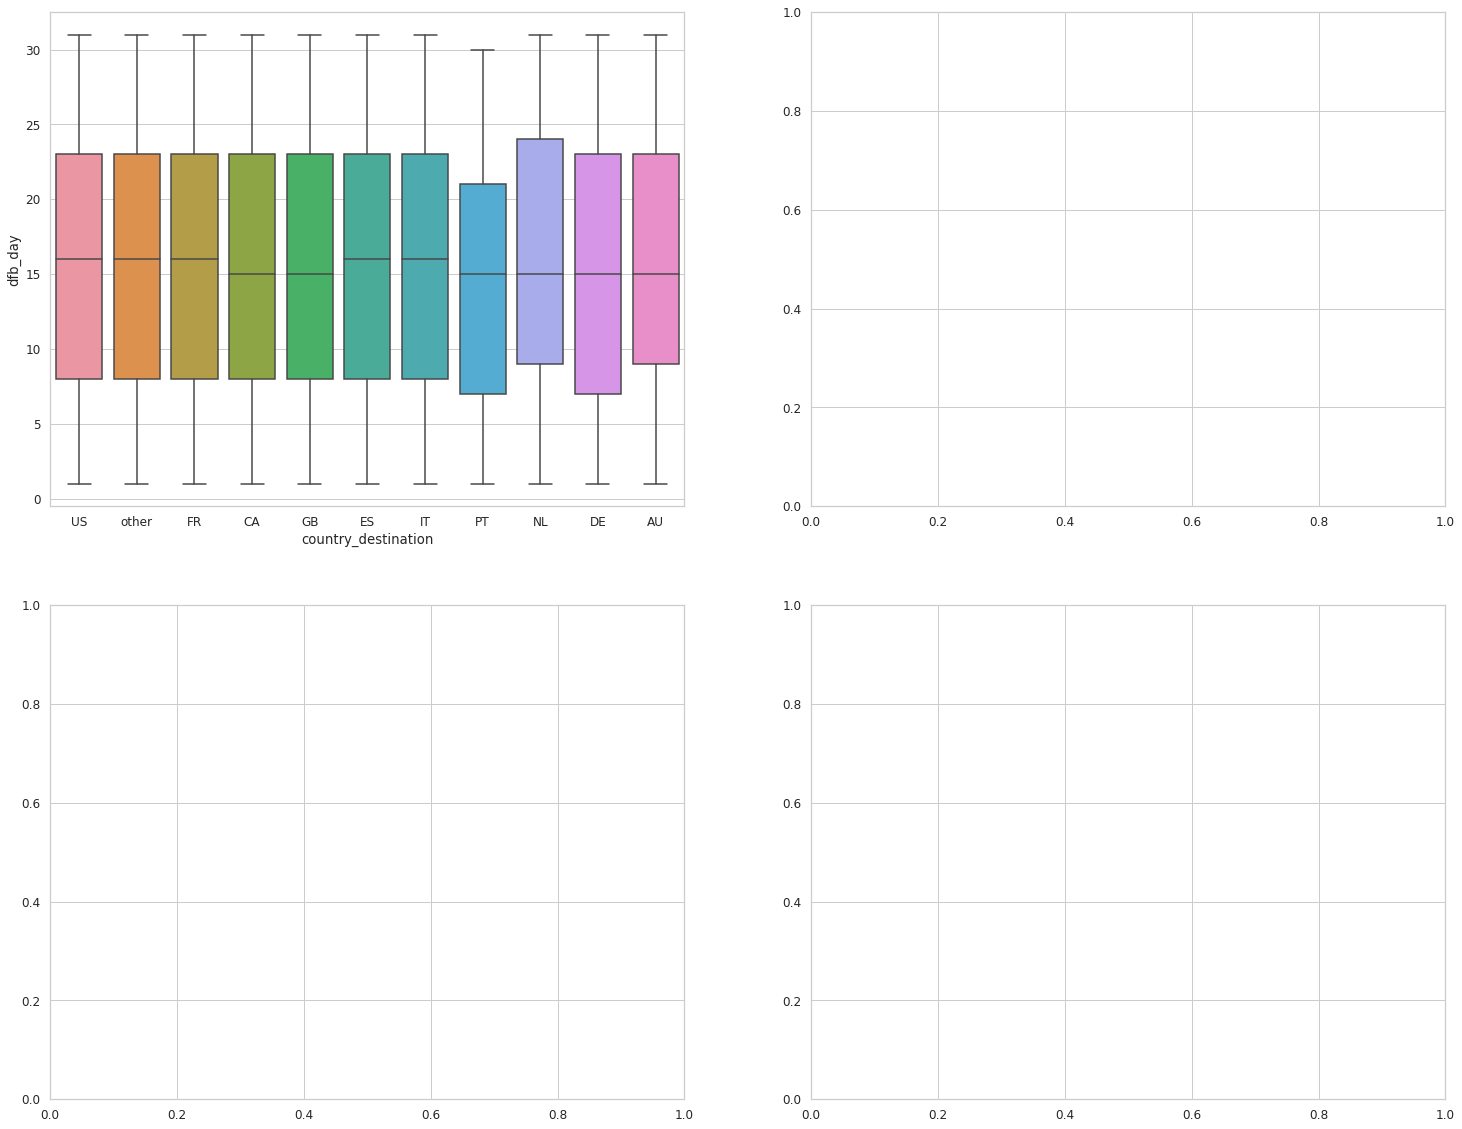

In [71]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='dfb_day', data=train_org, ax=subplot)

In [72]:
train_org.drop(['dfb_day','dfb_month','dfb_year'],axis = 1,inplace = True)
test_org.drop(['dfb_day','dfb_month','dfb_year'],axis = 1,inplace = True)

In [73]:
#age
train_org['age']

2         56.0
3         42.0
4         41.0
5          NaN
6         46.0
          ... 
170118    27.0
170122    76.0
170125    38.0
170128    51.0
170134    32.0
Name: age, Length: 72330, dtype: float64

In [74]:
#Removing the outliers
train_org.loc[train_org.age > 100, 'age'] = np.nan
train_org.loc[train_org.age < 18, 'age'] = np.nan
test_org.loc[test_org.age > 100, 'age'] = np.nan
test_org.loc[test_org.age < 18, 'age'] = np.nan

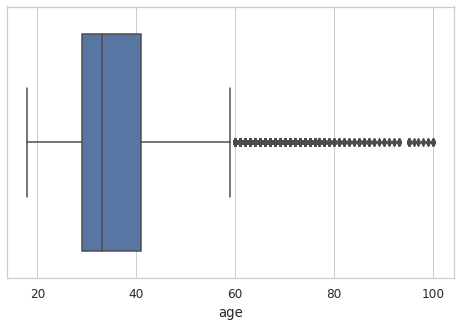

In [75]:
sns.boxplot(train_org['age'])

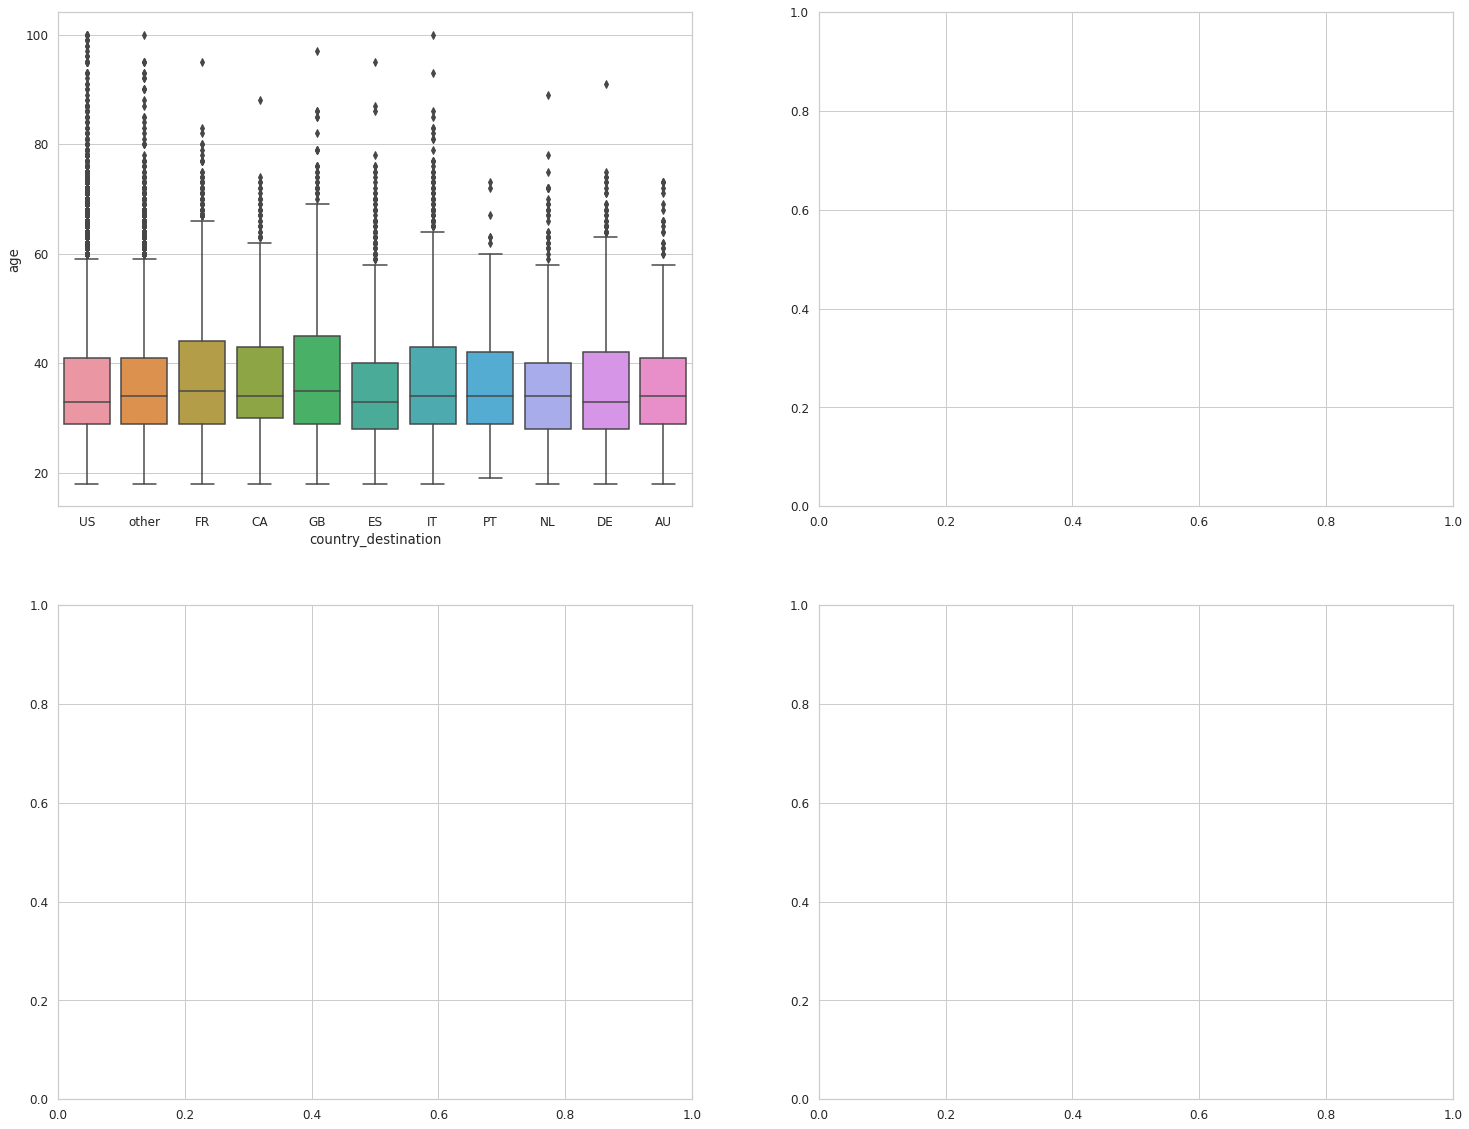

In [76]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='age', data=train_org, ax=subplot)

In [78]:
train_org['age'] = train_org['age'].fillna(-1)
test_org['age'] = test_org['age'].fillna(-1)

In [79]:
train_org.isnull().sum()

id                         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dac_year                   0
tfa_year                   0
tfa_month                  0
dtype: int64

In [80]:
test_org.isnull().sum()

id                         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
dac_year                   0
tfa_year                   0
tfa_month                  0
dtype: int64

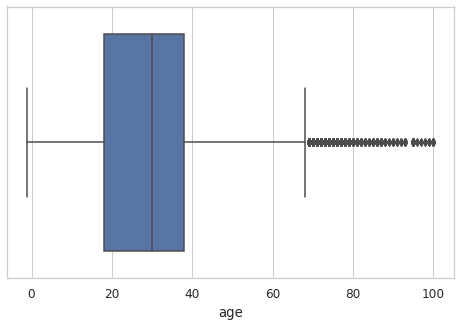

In [81]:
sns.boxplot(train_org['age'])

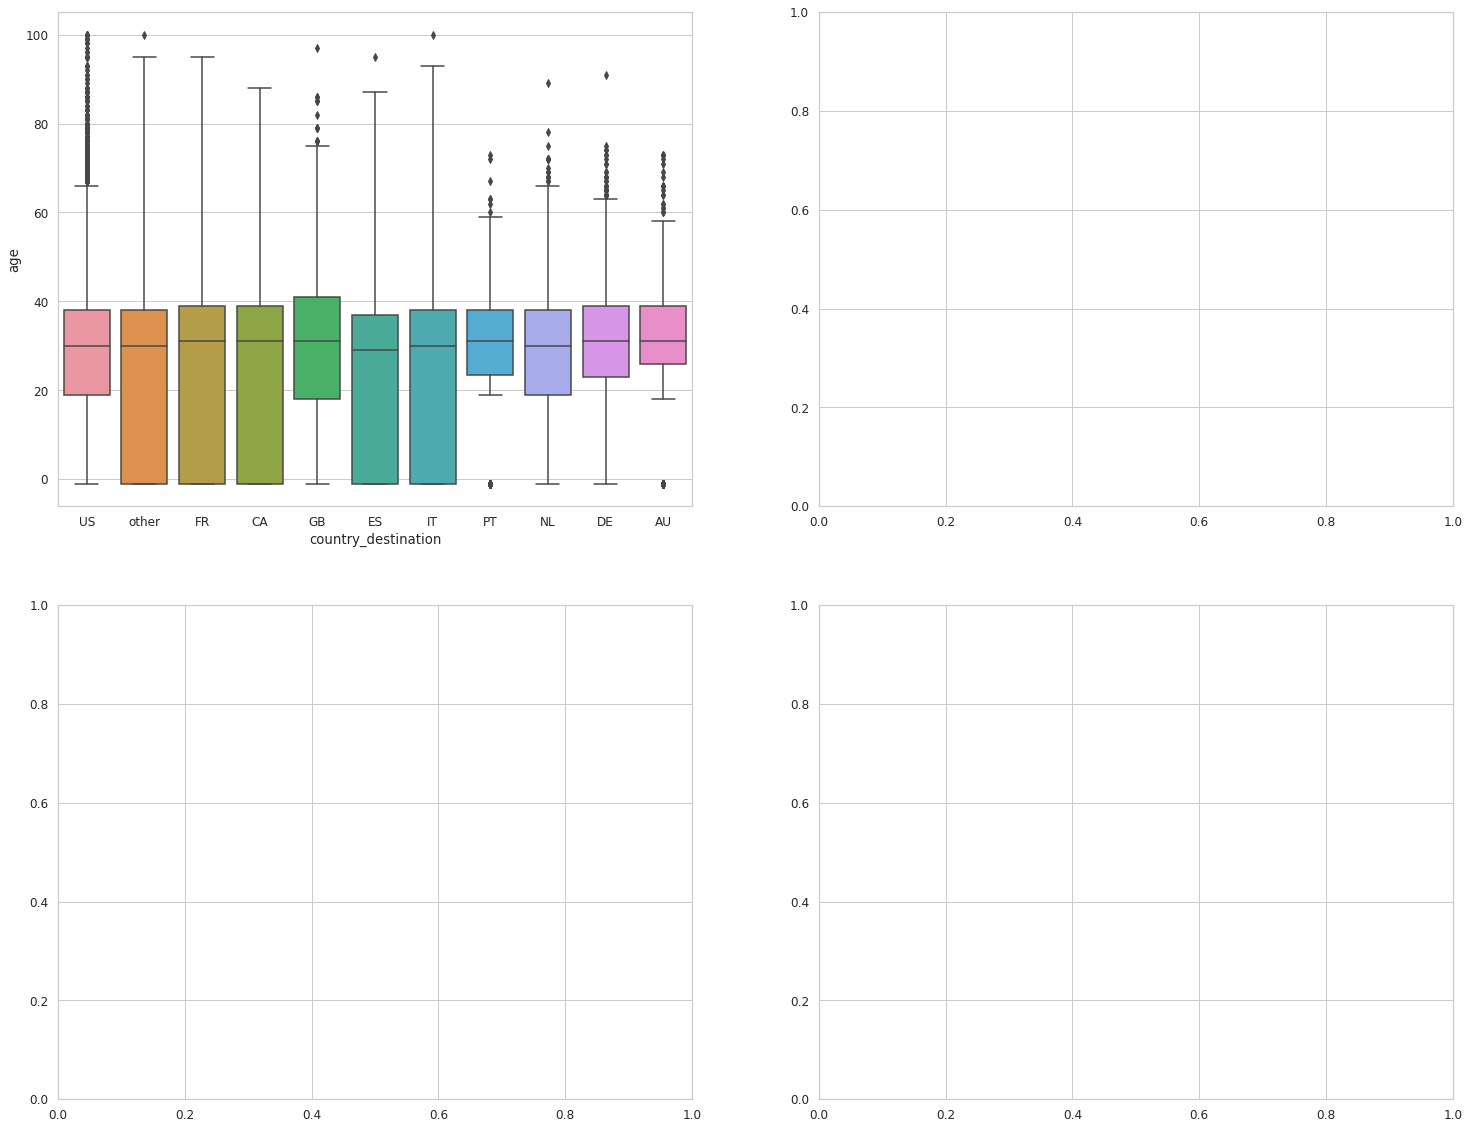

In [82]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='age', data=train_org, ax=subplot)

In [85]:
#signup_flow
train_org['signup_flow']

2         3
3         0
4         0
5         0
6         0
         ..
170118    0
170122    0
170125    0
170128    0
170134    0
Name: signup_flow, Length: 72330, dtype: int64

In [86]:
train_org['signup_flow'].value_counts()

0     56211
3      5615
2      3679
12     2761
25     2216
24     1054
23      296
1       169
6       164
21       84
8        70
15        4
20        2
16        2
5         2
10        1
Name: signup_flow, dtype: int64

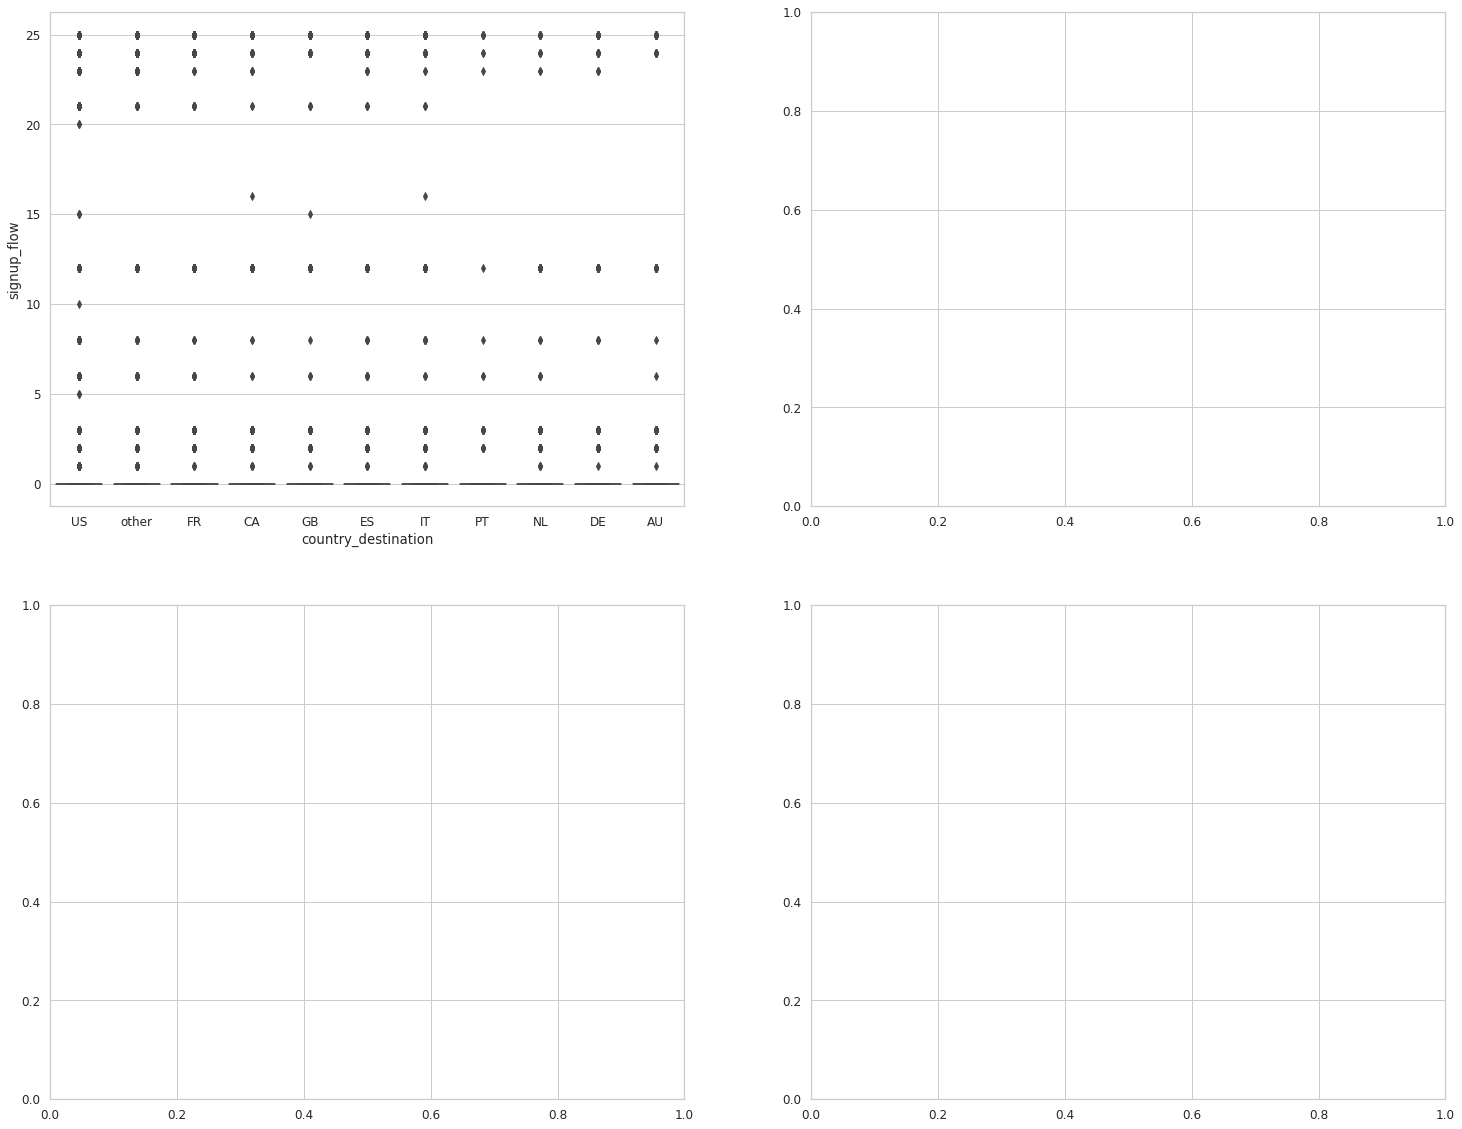

In [88]:
categorical = ['country_destination']
fig, ax = plt.subplots(2, 2, figsize=(25, 20))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='signup_flow', data=train_org, ax=subplot)

In [90]:
train_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72330 entries, 2 to 170134
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       72330 non-null  object 
 1   gender                   72330 non-null  object 
 2   age                      72330 non-null  float64
 3   signup_method            72330 non-null  object 
 4   signup_flow              72330 non-null  int64  
 5   language                 72330 non-null  object 
 6   affiliate_channel        72330 non-null  object 
 7   affiliate_provider       72330 non-null  object 
 8   first_affiliate_tracked  72330 non-null  object 
 9   signup_app               72330 non-null  object 
 10  first_device_type        72330 non-null  object 
 11  first_browser            72330 non-null  object 
 12  country_destination      72330 non-null  object 
 13  dac_year                 72330 non-null  int64  
 14  tfa_year             

In [91]:
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       43314 non-null  object 
 1   gender                   43314 non-null  object 
 2   age                      43314 non-null  float64
 3   signup_method            43314 non-null  object 
 4   signup_flow              43314 non-null  int64  
 5   language                 43314 non-null  object 
 6   affiliate_channel        43314 non-null  object 
 7   affiliate_provider       43314 non-null  object 
 8   first_affiliate_tracked  43314 non-null  object 
 9   signup_app               43314 non-null  object 
 10  first_device_type        43314 non-null  object 
 11  first_browser            43314 non-null  object 
 12  dac_year                 43314 non-null  int64  
 13  tfa_year                 43314 non-null  int64  
 14  tfa_month             

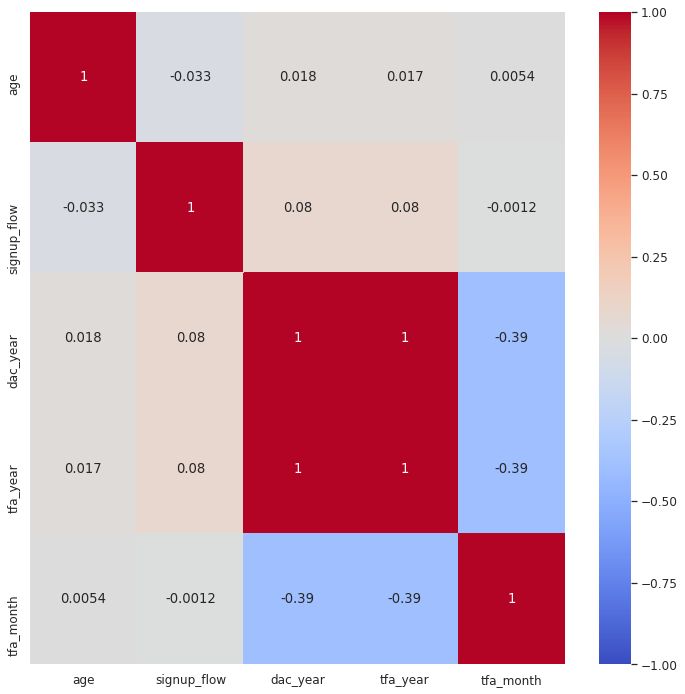

In [94]:
f, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(train_org.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [95]:
train_org.drop(['tfa_year'],axis = 1,inplace = True)
test_org.drop(['tfa_year'],axis = 1,inplace = True)

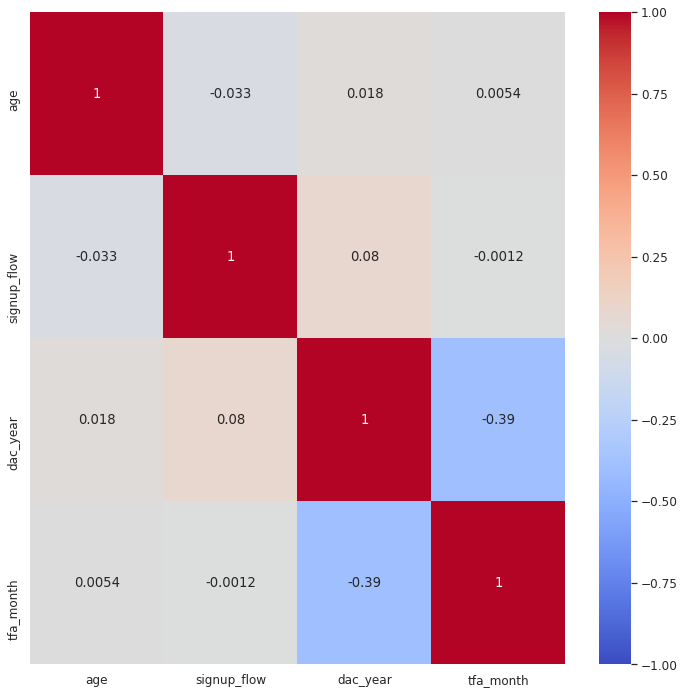

In [96]:
f, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(train_org.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [97]:
l = label()
train_org['country_destination'] = l.fit_transform(train_org['country_destination'])
test_id = test_org['id']
train_org.drop(['id'],axis = 1,inplace = True)
test_org.drop(['id'],axis = 1,inplace = True)

In [101]:
train_countries = train_org['country_destination']
train_org.drop(['country_destination'], axis = 1, inplace = True)
train_org['train'] = 1
test_org['train'] = 0
combined = pd.concat([train_org,test_org])
combined = pd.get_dummies(combined)
train_df = combined[combined["train"] == 1]
test_df = combined[combined["train"] == 0]
train_df.drop(["train"],axis = 1,inplace = True)
test_df.drop(["train"],axis = 1,inplace = True)
x_train, x_test, y_train, y_test = train_test_split(train_df,train_countries,test_size=0.3,shuffle=True,random_state=random_seed,stratify=train_countries)

In [111]:
def metrics(true, preds):
    accuracy = accuracy_score(true, preds)
    recall = recall_score(true, preds,average='weighted')
    precision = precision_score(true, preds,average='weighted')
    f1score = f1_score(true, preds,average='weighted')
    print ('accuracy: {}, recall: {}, precision: {}, f1-score: {}'.format(accuracy, recall, precision, f1score))

In [122]:
p={'task': 'train', 'boosting_type': 'gbdt', 'objective': 'multiclass', 'num_class': 11, 'metric': ['multi_error'], 'learning_rate': 0.03, 'num_leaves': 60, 'max_depth': 4, 'feature_fraction': 0.45, 'bagging_fraction': 0.3, 'reg_alpha': 0.15, 'reg_lambda': 0.15, 'min_child_weight': 0}
lgb = lgb.LGBMClassifier(n_jobs=-1,**p)
rf = RandomForestClassifier(n_estimators = 225,max_depth=18,random_state=42)
xgb = XGBClassifier(eta = 0.05, max_depth = 6, alpha = 1.0, eval_metric = "merror", objective='multi:softprob', subsample=0.5, colsample_bytree=0.3, num_class = 11, nthread = 24)
estimators=[('rf',rf),('xgb',xgb),('lgb',lgb)]
VC=VotingClassifier(estimators,voting='soft',weights=[0.1,0.3,0.6])
VC=VC.fit(x_train,y_train)

In [137]:
preds = VC.predict(x_test)
metrics(y_test, preds)

In [143]:
from sklearn.metrics import classification_report
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.70      0.83     21699
          10       0.00      0.00      0.00         0

    accuracy                           0.70     21699
   macro avg       0.09      0.06      0.08     21699
weighted avg       1.00      0.70      0.83     21699



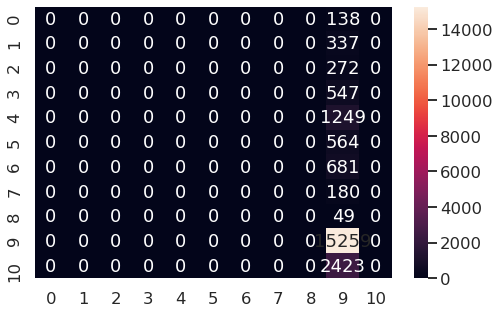

In [144]:
from sklearn.metrics import confusion_matrix
sns.set_context('talk')
cm=confusion_matrix(y_test,preds)
ax=sns.heatmap(cm,annot=True,fmt='d')

In [147]:
VC.fit(train_df,train_countries)
y_test = VC.predict_proba(test_df)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=18,
                                                     n_estimators=225,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(alpha=1.0, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, eta=0.05,
                                            eval_metric='merror', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate...
                                            random_state=None, reg_alpha=None,
   

In [148]:
ids = []
cts = []
bool_dfb = pd.isnull(test_dfb)
for i in range(len(test_id)):
    if bool_dfb[i]:
        ids += [test_id[i]] * 3
        cts += ['NDF','NDF','NDF']
    else:
        idx = test_id[i]
        ids += [idx] * 3
        cts += l.inverse_transform(np.argsort(y_test[i])[::-1])[:3].tolist()

In [149]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country_destination'])
sub.to_csv('sub11.csv',index=False)